# Introduction to Natural Lanuage Processing

## Word Embeddings: Representing Words Numerically

In [1]:
import numpy as np
import matplotlib.pyplot as plt

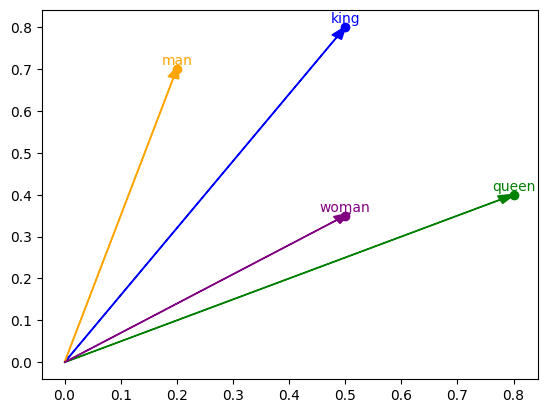

In [2]:
king = np.array([0.5, 0.8])
man = np.array([0.2, 0.7])
queen =  np.array([0.8, .4])
woman = np.array([0.5, 0.35])

def plot(xy, label, color):
    plt.plot(xy[0], xy[1], 'o', color=color)
    plt.arrow(0, 0, xy[0] * 0.97, xy[1] * 0.97, head_width=0.02, color=color)
    plt.annotate(label, xy + [0, 0.01], ha='center', color=color)

plot(king, 'king', 'blue')
plot(man, 'man', 'orange')
plot(queen, 'queen', 'green')
plot(woman, 'woman', 'purple')

We would like a representation of words that does not require manual feature engineering, but allows for generalization between related words—words that are related syntactically (“colorless” and “ideal” are both adjectives), semantically (“cat” and “kitten” are both felines), topically (“sunny” and “sleet” are both weather terms), in terms of sentiment (“awesome” has opposite sentiment to “cringeworthy”), or otherwise.

__How should we encode a word into an input vector x for use in a neural network?__

- __one-hot vector__, we encode the ith word in the dictionary with a 1 bit in the ith input position and a 0 in all the other positions.

  - But such a representation would not capture the similarity between words.

In [3]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
data = np.asarray([['Natural'], ['Lanuage'], ['Processing']])
enc.fit(data)
enc.categories_

[array(['Lanuage', 'Natural', 'Processing'], dtype='<U10')]

In [4]:
onehotlabels = enc.transform(data).toarray()
onehotlabels

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]])




- term frequency-inverse document frequency (TF-IDF)

    - TF-IDF will tell you how important a single word is in a corpus by assigning it a weight and, at the same time, down-weight common words like ,"a", "and", and "the". 

    
    - This calculated weight gives us a feature for a single word TF-IDF, and also the relevance of the features across the vocabulary.

$$tf(t, d) = \frac{f_{t,d}} {\sum_{t' ∈ d} f_{t',d}}$$

- principal components analysis (PCA) and singular value decomposition (SVD)

          - didn’t quite scale

  <br>





  
- latent semantic analysis (LSA) and latent Dirichlet allocation

      - principle behind them is that words that occur close together more frequently have more important relationships.

<br>

__Limitation of traditional methods__

- As our corpus starts to grow, we start to run into two problems: the curse of dimensionality and compute scale

### Word2Vec

In 2013, researchers at Google came up with an elegant solution to this problem using neural networks, called Word2Vec

There are two modeling approaches to Word2Vec 

    - continuous bag of words (CBOW) and skipgrams, both of which generate dense vectors of embeddings but model the problem slightly differently. 
    
The end-goal of the Word2Vec model in either case is to learn the parameters that maximize that probability of a given word or group of words being an accurate prediction

<img src="fig/wv.png" width=500 height=500 />

### CBOW Neural Network architecture

<img src="fig/cbow.png" width=500 height=500 />

#### Similarity measure

The cosine of the angle between two vectors is often used as a measure of the similarity of two vectors.

$$ \begin{eqnarray}
v_1 \cdot v_2 &= ||v_1|| ||v_2|| \cos(\theta)\\
\cos(\theta) &= \frac{v_1 \cdot v_2}{||v_1|| ||v_2||}
\end{eqnarray}$$

In [5]:
def similarity(a, b):
    return np.dot(a, b) / (np.sqrt(np.dot(a, a)) * np.sqrt(np.dot(b, b)))

In [6]:
#%pip install gensim

In [1]:
import torch
import torch.nn as nn

### Text Preparation

In [2]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right - this is our context window
EMBEDDING_DIM = 100  # size of the embeddings matrix - we'll get to this in a bit

In [3]:
# Our tiny training dataset

raw_text = """To Kara's astonishment, she discovers that a portal has opened in her bedroom closet and two goblins have fallen through! They refuse to return to the fairy realms and be drafted for an impending war. 
In an attempt to roust the pesky creatures, Kara falls through the portal, 
smack into the middle of a huge war. Kara meets Queen Selinda, who appoints 
Kara as a Fairy Princess and assigns her an impossible task: 
to put an end to the war using her diplomatic skills.""".split()

In [4]:
# Text preprocessing get only individual words
vocab = set(raw_text) 
vocab_size = len(vocab)

In [5]:
print(vocab_size)

64


In [6]:
print(vocab)

{'falls', 'the', 'into', 'assigns', 'Fairy', 'an', 'and', 'fairy', 'astonishment,', 'huge', "Kara's", 'who', 'a', 'goblins', 'Selinda,', 'for', 'fallen', 'impossible', 'she', 'attempt', 'have', 'impending', 'be', 'bedroom', 'To', 'to', 'Princess', 'end', 'using', 'refuse', 'drafted', 'skills.', 'portal', 'portal,', 'realms', 'pesky', 'opened', 'Queen', 'put', 'as', 'diplomatic', 'meets', 'middle', 'appoints', 'smack', 'two', 'through', 'task:', 'through!', 'war.', 'that', 'discovers', 'In', 'return', 'creatures,', 'roust', 'in', 'of', 'Kara', 'has', 'closet', 'They', 'her', 'war'}


In [7]:
# we create simple mappings of word to an index of the word

word_to_ix = {word: ix for ix, word in enumerate(vocab)}
ix_to_word = {ix: word for ix, word in enumerate(vocab)}

In [8]:
print(word_to_ix)

{'falls': 0, 'the': 1, 'into': 2, 'assigns': 3, 'Fairy': 4, 'an': 5, 'and': 6, 'fairy': 7, 'astonishment,': 8, 'huge': 9, "Kara's": 10, 'who': 11, 'a': 12, 'goblins': 13, 'Selinda,': 14, 'for': 15, 'fallen': 16, 'impossible': 17, 'she': 18, 'attempt': 19, 'have': 20, 'impending': 21, 'be': 22, 'bedroom': 23, 'To': 24, 'to': 25, 'Princess': 26, 'end': 27, 'using': 28, 'refuse': 29, 'drafted': 30, 'skills.': 31, 'portal': 32, 'portal,': 33, 'realms': 34, 'pesky': 35, 'opened': 36, 'Queen': 37, 'put': 38, 'as': 39, 'diplomatic': 40, 'meets': 41, 'middle': 42, 'appoints': 43, 'smack': 44, 'two': 45, 'through': 46, 'task:': 47, 'through!': 48, 'war.': 49, 'that': 50, 'discovers': 51, 'In': 52, 'return': 53, 'creatures,': 54, 'roust': 55, 'in': 56, 'of': 57, 'Kara': 58, 'has': 59, 'closet': 60, 'They': 61, 'her': 62, 'war': 63}


In [9]:
print(ix_to_word)

{0: 'falls', 1: 'the', 2: 'into', 3: 'assigns', 4: 'Fairy', 5: 'an', 6: 'and', 7: 'fairy', 8: 'astonishment,', 9: 'huge', 10: "Kara's", 11: 'who', 12: 'a', 13: 'goblins', 14: 'Selinda,', 15: 'for', 16: 'fallen', 17: 'impossible', 18: 'she', 19: 'attempt', 20: 'have', 21: 'impending', 22: 'be', 23: 'bedroom', 24: 'To', 25: 'to', 26: 'Princess', 27: 'end', 28: 'using', 29: 'refuse', 30: 'drafted', 31: 'skills.', 32: 'portal', 33: 'portal,', 34: 'realms', 35: 'pesky', 36: 'opened', 37: 'Queen', 38: 'put', 39: 'as', 40: 'diplomatic', 41: 'meets', 42: 'middle', 43: 'appoints', 44: 'smack', 45: 'two', 46: 'through', 47: 'task:', 48: 'through!', 49: 'war.', 50: 'that', 51: 'discovers', 52: 'In', 53: 'return', 54: 'creatures,', 55: 'roust', 56: 'in', 57: 'of', 58: 'Kara', 59: 'has', 60: 'closet', 61: 'They', 62: 'her', 63: 'war'}


In [10]:
# Creating our training data and context window

def make_context_vector(context, word_to_ix):
    idxs = [word_to_ix[w] for w in context]
    return torch.tensor(idxs, dtype=torch.long)


data = []
for i in range(CONTEXT_SIZE, len(raw_text) - CONTEXT_SIZE):
    context = [raw_text[i - 2], raw_text[i - 1], raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))

In [11]:
# We have our [input, input, input, input, target]
# based on the context window of +2 words -2 words
# you can see how we're building words close to each other now

print(*data[0:10], sep="\n")

(['To', "Kara's", 'she', 'discovers'], 'astonishment,')
(["Kara's", 'astonishment,', 'discovers', 'that'], 'she')
(['astonishment,', 'she', 'that', 'a'], 'discovers')
(['she', 'discovers', 'a', 'portal'], 'that')
(['discovers', 'that', 'portal', 'has'], 'a')
(['that', 'a', 'has', 'opened'], 'portal')
(['a', 'portal', 'opened', 'in'], 'has')
(['portal', 'has', 'in', 'her'], 'opened')
(['has', 'opened', 'her', 'bedroom'], 'in')
(['opened', 'in', 'bedroom', 'closet'], 'her')


### CBOW Architecture

We have two layers in the CBOW implementation of Word2Vec: an input Embedding layer that maps each word to a space in the embedding dictionary, a hidden linear activation layer, and then the output layer that is the proportional probabilities softmax of all the correct words given an input window. 
<br><br>

The critical part is the first part, creating the Embeddings lookup.
<br><br>
First, we associate each word in the vocabulary with an index, aka {'she': 0, 'middle': 1, 'put': 2}
<br><br>
Then, what we want to do is create an embeddings table, or matrix, that we will multiply with these indices to map each one to its correct place in relation to the other indices via a table lookup, based on how many vectors you'd like to represent the word.

In [16]:
# source: https://github.com/veekaybee/viberary/blob/main/src/notebooks/cbow.ipynb

class CBOW(torch.nn.Module):
    def __init__(
        self, vocab_size, embedding_dim
    ):  # we pass in vocab_size and embedding_dim as hyperparams
        super(CBOW, self).__init__()

        # out: 1 x embedding_dim
        self.embeddings = nn.Embedding(
            vocab_size, embedding_dim
        )  # initialize an Embedding matrix based on our inputs
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.activation_function1 = nn.ReLU()

        # out: 1 x vocab_size
        self.linear2 = nn.Linear(128, vocab_size)
        self.activation_function2 = nn.LogSoftmax(dim=-1)

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1, -1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.tensor([word_to_ix[word]])
        # Embeddings lookup of a single word once the Embeddings layer has been optimized
        return self.embeddings(word).view(1, -1)

In [17]:
# We initialize the model:

model = CBOW(vocab_size, EMBEDDING_DIM)

In [18]:
# then, we initialize the loss function
# (aka how close our predicted word is to the actual word and how we want to minimize it using the optimizer)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [19]:
# Training

# 50 to start with, no correct answer here
for epoch in range(50):
    # we start tracking how accurate our intial words are
    total_loss = 0

    # for the x, y in the training data:
    for context, target in data:
        context_vector = make_context_vector(context, word_to_ix)

        # we look at loss
        log_probs = model(context_vector)

        # we compare the loss from what the actual word is related to the probaility of the words
        total_loss += loss_function(log_probs, torch.tensor([word_to_ix[target]]))

    # optimize at the end of each epoch
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # Log out some metrics to see if loss decreases
    print("end of epoch {} | loss {:2.3f}".format(epoch, total_loss))

end of epoch 0 | loss 335.677
end of epoch 1 | loss 323.861
end of epoch 2 | loss 312.638
end of epoch 3 | loss 301.922
end of epoch 4 | loss 291.625
end of epoch 5 | loss 281.688
end of epoch 6 | loss 272.061
end of epoch 7 | loss 262.706
end of epoch 8 | loss 253.553
end of epoch 9 | loss 244.600
end of epoch 10 | loss 235.807
end of epoch 11 | loss 227.160
end of epoch 12 | loss 218.676
end of epoch 13 | loss 210.318
end of epoch 14 | loss 202.085
end of epoch 15 | loss 193.951
end of epoch 16 | loss 185.935
end of epoch 17 | loss 178.028
end of epoch 18 | loss 170.234
end of epoch 19 | loss 162.578
end of epoch 20 | loss 155.063
end of epoch 21 | loss 147.699
end of epoch 22 | loss 140.464
end of epoch 23 | loss 133.394
end of epoch 24 | loss 126.494
end of epoch 25 | loss 119.797
end of epoch 26 | loss 113.312
end of epoch 27 | loss 107.062
end of epoch 28 | loss 101.045
end of epoch 29 | loss 95.283
end of epoch 30 | loss 89.780
end of epoch 31 | loss 84.535
end of epoch 32 | los

In [20]:
# Now, let's test to see if the model predicts the correct word using our initial input
context = ["Kara", "falls", "the", "portal"]
context_vector = make_context_vector(context, word_to_ix)
a = model(context_vector)

In [23]:
print(f'Raw text: {" ".join(raw_text)}\n')
print(f"Context: {context}\n")
print(f"Prediction: {ix_to_word[torch.argmax(a[0]).item()]}")

Raw text: To Kara's astonishment, she discovers that a portal has opened in her bedroom closet and two goblins have fallen through! They refuse to return to the fairy realms and be drafted for an impending war. In an attempt to roust the pesky creatures, Kara falls through the portal, smack into the middle of a huge war. Kara meets Queen Selinda, who appoints Kara as a Fairy Princess and assigns her an impossible task: to put an end to the war using her diplomatic skills.

Context: ['Kara', 'falls', 'the', 'portal']

Prediction: creatures,


In [24]:
# Now let's get what we care about, which is the embeddings!
print(f"Getting vectors for a sequence:\n", model.embeddings(torch.LongTensor([1, 2, 3])))

Getting vectors for a sequence:
 tensor([[ 0.2565,  1.2598, -0.1168,  0.9607,  0.4741, -2.2960,  2.4722, -0.1103,
          1.1789,  0.6025, -0.6956,  1.3150, -0.7408,  0.3857,  0.8122, -1.3053,
          0.8551, -0.9123,  0.4001, -0.5079, -0.1585, -1.4396,  0.2016, -0.2898,
          0.1048,  1.0222,  0.0376, -0.2260,  0.3855,  0.1508, -0.9686, -1.0810,
         -0.2942, -1.9078, -0.1977,  1.3578,  1.2063,  1.2658,  1.4797, -0.8926,
          0.5919,  0.2306,  1.7689, -0.5110,  1.8687, -0.6247,  0.8938, -0.1699,
         -0.1281,  2.1315, -1.1590, -0.8723, -0.5465, -0.1630, -1.0591, -0.5404,
         -1.6623,  0.3853, -1.4852, -1.5185,  1.5000, -0.4165, -0.8873,  0.0586,
         -0.1319, -0.4038, -1.6258,  1.6007,  0.4633,  0.6161, -0.1024,  0.4655,
         -0.4803,  0.3946, -0.4051,  0.1718,  1.5302, -0.1691,  1.0236,  1.0961,
         -0.9687,  0.8695, -0.2277,  0.1034,  0.6405,  0.0540,  0.9215, -1.8690,
          0.3934,  0.1759, -0.6211,  1.6977, -3.4360,  0.6509,  0.2835, -1.0

In [25]:
print(
    "Getting weights:\n", model.embeddings.weight.data[1]
)  # we can get the entire matrix this way

Getting weights:
 tensor([ 0.2565,  1.2598, -0.1168,  0.9607,  0.4741, -2.2960,  2.4722, -0.1103,
         1.1789,  0.6025, -0.6956,  1.3150, -0.7408,  0.3857,  0.8122, -1.3053,
         0.8551, -0.9123,  0.4001, -0.5079, -0.1585, -1.4396,  0.2016, -0.2898,
         0.1048,  1.0222,  0.0376, -0.2260,  0.3855,  0.1508, -0.9686, -1.0810,
        -0.2942, -1.9078, -0.1977,  1.3578,  1.2063,  1.2658,  1.4797, -0.8926,
         0.5919,  0.2306,  1.7689, -0.5110,  1.8687, -0.6247,  0.8938, -0.1699,
        -0.1281,  2.1315, -1.1590, -0.8723, -0.5465, -0.1630, -1.0591, -0.5404,
        -1.6623,  0.3853, -1.4852, -1.5185,  1.5000, -0.4165, -0.8873,  0.0586,
        -0.1319, -0.4038, -1.6258,  1.6007,  0.4633,  0.6161, -0.1024,  0.4655,
        -0.4803,  0.3946, -0.4051,  0.1718,  1.5302, -0.1691,  1.0236,  1.0961,
        -0.9687,  0.8695, -0.2277,  0.1034,  0.6405,  0.0540,  0.9215, -1.8690,
         0.3934,  0.1759, -0.6211,  1.6977, -3.4360,  0.6509,  0.2835, -1.0704,
        -0.7688,  1.57

In [26]:
# And, what we actually care about is being able to look up individual words with their embeddings:
torch.set_printoptions(threshold=10_000)
print(f"Embedding for Kara: {model.embeddings.weight[word_to_ix['Kara']]}")

Embedding for Kara: tensor([-1.3658,  0.9565, -2.1571,  0.6788,  2.2240,  0.5504, -1.2280, -0.6800,
        -1.2993, -1.0482,  1.4272, -0.0428, -1.0548,  0.3322, -0.1280,  0.5258,
         1.1979,  0.4124, -0.8071, -0.3402,  0.7135,  1.3369,  0.7310, -0.4913,
        -0.3217,  2.1969,  0.7870,  0.1528, -0.6103, -0.7641, -0.6538, -0.4319,
        -0.4860,  0.5080, -2.6956, -0.4862, -0.4675, -0.1235, -1.4961, -1.0936,
         0.8747,  0.3275,  0.3107,  0.7023, -0.1978, -0.3140, -1.7115,  0.7202,
        -1.0560,  0.2375, -0.2719,  0.9415,  1.3043, -1.2429, -0.6484, -0.7739,
         1.2586, -1.2827, -0.0932,  0.9618,  1.5160, -0.4782, -1.7769,  0.3272,
         0.0732,  0.8728, -1.0347, -0.4577, -1.3084,  2.7901,  0.6732,  0.2802,
        -0.1838,  0.2042, -2.1433, -0.4499,  0.6727,  0.3302,  0.2856, -0.3775,
        -0.2914, -0.0078, -0.4314,  0.0489, -0.1393, -0.6045,  1.1095, -0.7457,
        -1.0530,  0.2578,  0.0901,  0.7013,  0.7969, -0.4131, -0.6791,  0.7056,
        -0.1481, -0.

In [27]:
#%pip install plotly

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


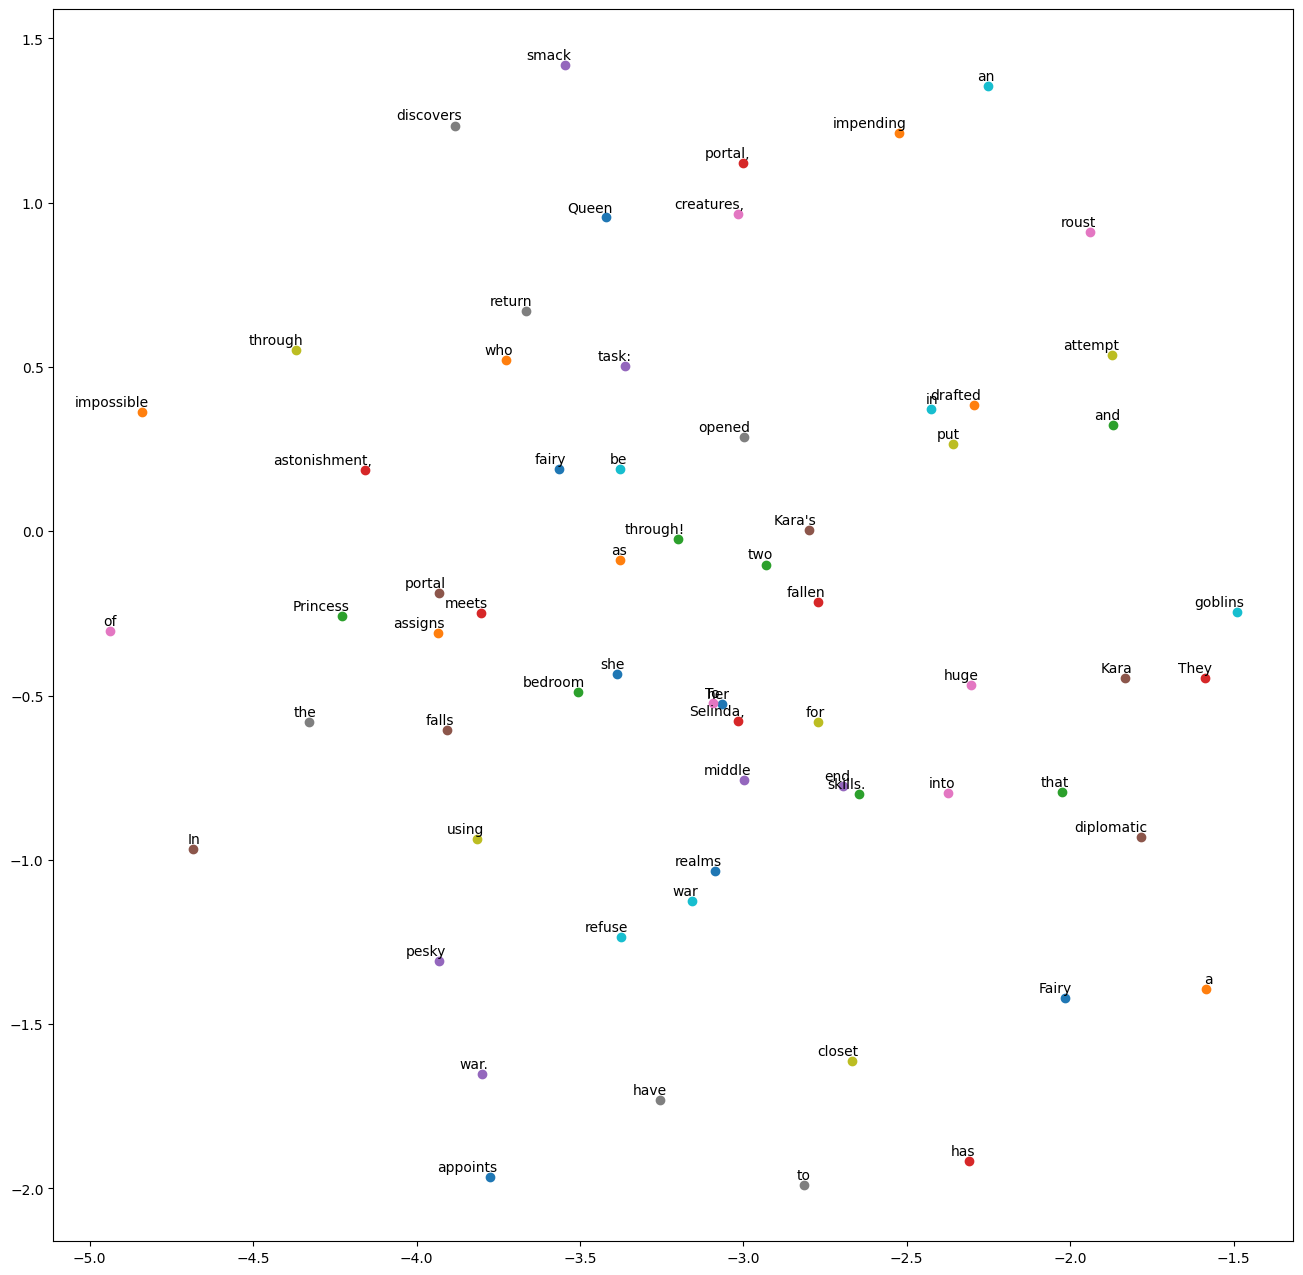

In [28]:
from sklearn.manifold import TSNE 

def reduce_dimensions(model, n_words=64):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.embeddings.weight[:].detach().numpy())
    labels = np.asarray(list(ix_to_word.values()))
    
    vectors = vectors.reshape(-1,100)
    

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model, n_words=64)

plt.figure(figsize=(16, 16)) 
for i in range(len(x_vals)):
    plt.scatter(x_vals[i],y_vals[i])
    plt.annotate(labels[i],
    xy=(x_vals[i], y_vals[i]),
    xytext=(5, 2),
    textcoords='offset points',
    ha='right',
    va='bottom')
plt.show()
